In [1]:
import os
from glob import glob
import numpy as np
import pandas as pd
import xarray as xr
import dask
import gev_utils as gevu
import sa_utils as sau
import plotting_utils as pu

from utils import city_list
from utils import roar_code_path as project_code_path
from utils import roar_data_path as project_data_path
from utils import metric_ids, gard_gcms

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [2]:
# Set fonts
from matplotlib import font_manager
font_dirs = ["/storage/home/dcl5300/fonts"]

font_files = font_manager.findSystemFonts(fontpaths=font_dirs)

for font_file in font_files:
    font_manager.fontManager.addfont(font_file)
    
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.size"] = 12
plt.rcParams["font.sans-serif"] = "Arial"
plt.rcParams["pdf.fonttype"] = 42
plt.rcParams["axes.linewidth"] = 1.5

### Preliminaries

In [3]:
def plot_uc_metric(metric_id, proj_slice, return_period, norm):
    # For titles
    title_labels = {
        'max_tasmax':f'{return_period} year return level: annual maximum temperature',
        'max_cdd':f'{return_period} year return level: annual 1-day maximum CDD',
        'max_hdd':f'{return_period} year return level: annual 1-day maximum HDD',
        'max_pr':f'{return_period} year return level: annual 1-day maximum precipitation',
        'min_tasmin':f'{return_period} year return level: annual minimum temperature',
    }

    # Make plot
    fig = plt.figure(figsize=(10, 6), layout='constrained')
    subfigs = fig.subfigures(2, 1)
    fig.suptitle(title_labels[metric_id], fontweight='bold')

    # Absolute value projection
    axsTop = subfigs[0].subplots(1, 4, subplot_kw=dict(projection=ccrs.LambertConformal()))
    subfigs[0].suptitle('Projection')
    p = pu.plot_uc_map(
        metric_id = metric_id, 
        proj_slice = proj_slice,
        hist_slice = None,
        return_period = return_period,
        fig = subfigs[0],
        axs = axsTop,
        title = None,
        norm = norm,
    )

    # Change from historical
    axsBottom = subfigs[1].subplots(1, 4, subplot_kw=dict(projection=ccrs.LambertConformal()))
    p = pu.plot_uc_map(
        metric_id = metric_id, 
        proj_slice = proj_slice,
        hist_slice = '1950-2014',
        return_period = return_period,
        fig = subfigs[1],
        axs = axsBottom,
        title = None,
        norm = norm,
    )
    subfigs[1].suptitle('Change from historical')

    plt.show()

## Analysis

In [4]:
# Calculate all and store
regrid_method = "nearest"
return_period = 100
proj_slice = "2050-2100"

# Loop through metrics
for metric_id in metric_ids:
    # Do for projection, change
    for hist_slice in [None, "1950-2014"]:
        # Check if done
        save_path = f"{project_data_path}/results/{metric_id}_{proj_slice}_{hist_slice}_{return_period}rl_{regrid_method}.nc"
        if not os.path.exists(save_path):
            # Calculate
            uc = sau.uc_all(metric_id=metric_id,
                            regrid_method=regrid_method,
                            proj_slice = proj_slice,
                            hist_slice = hist_slice,
                            return_period = return_period,
                            return_metric = False)
            # Store
            uc.to_netcdf(save_path)
            print(f"Done: {save_path.split('/')[-1]}")
            del uc # memory management
        else:
            print(f"Already done: {save_path.split('/')[-1]}")

Already done: max_tasmax_2050-2100_None_100rl_nearest.nc
Already done: max_tasmax_2050-2100_1950-2014_100rl_nearest.nc
Already done: min_tasmin_2050-2100_None_100rl_nearest.nc
Already done: min_tasmin_2050-2100_1950-2014_100rl_nearest.nc
Already done: max_cdd_2050-2100_None_100rl_nearest.nc
Already done: max_cdd_2050-2100_1950-2014_100rl_nearest.nc
Already done: max_hdd_2050-2100_None_100rl_nearest.nc
Already done: max_hdd_2050-2100_1950-2014_100rl_nearest.nc
Already done: max_pr_2050-2100_None_100rl_nearest.nc
Already done: max_pr_2050-2100_1950-2014_100rl_nearest.nc


## Plots

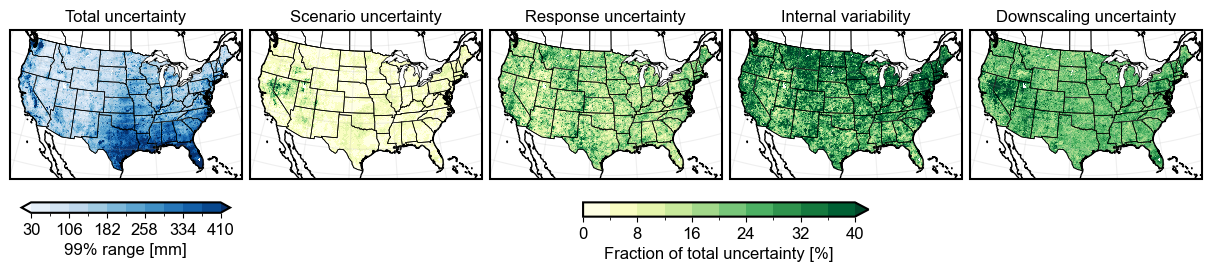

In [5]:
metric_id = 'max_pr'
return_period = 100
proj_slice = '2050-2100'

p = pu.plot_uc_map(
            metric_id = metric_id, 
            proj_slice = proj_slice,
            hist_slice = None,
            return_period = return_period,
            title = None,
            norm = 'uc_99w',
    )

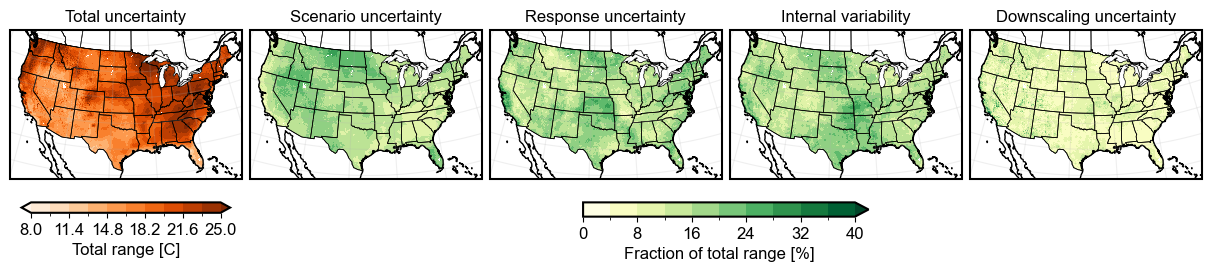

In [6]:
metric_id = 'max_tasmax'
return_period = 100
proj_slice = '2050-2100'

p = pu.plot_uc_map(
            metric_id = metric_id, 
            proj_slice = proj_slice,
            hist_slice = None,
            return_period = return_period,
            title = None,
            norm = 'total',
    )

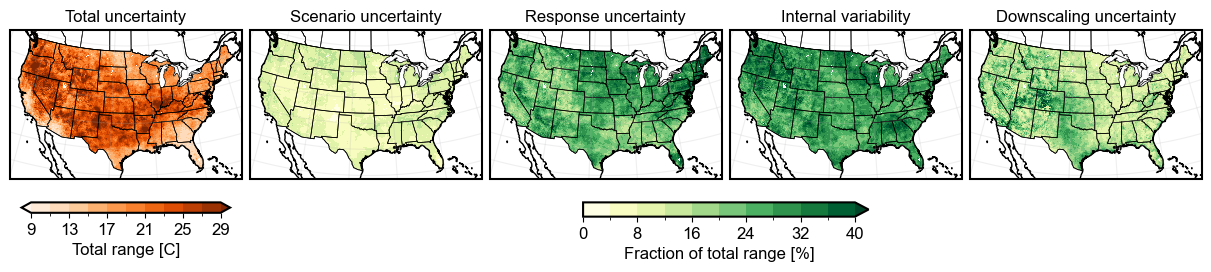

In [8]:
metric_id = 'min_tasmin'
return_period = 100
proj_slice = '2050-2100'

p = pu.plot_uc_map(
            metric_id = metric_id, 
            proj_slice = proj_slice,
            hist_slice = None,
            return_period = return_period,
            title = None,
            norm = 'total',
    )

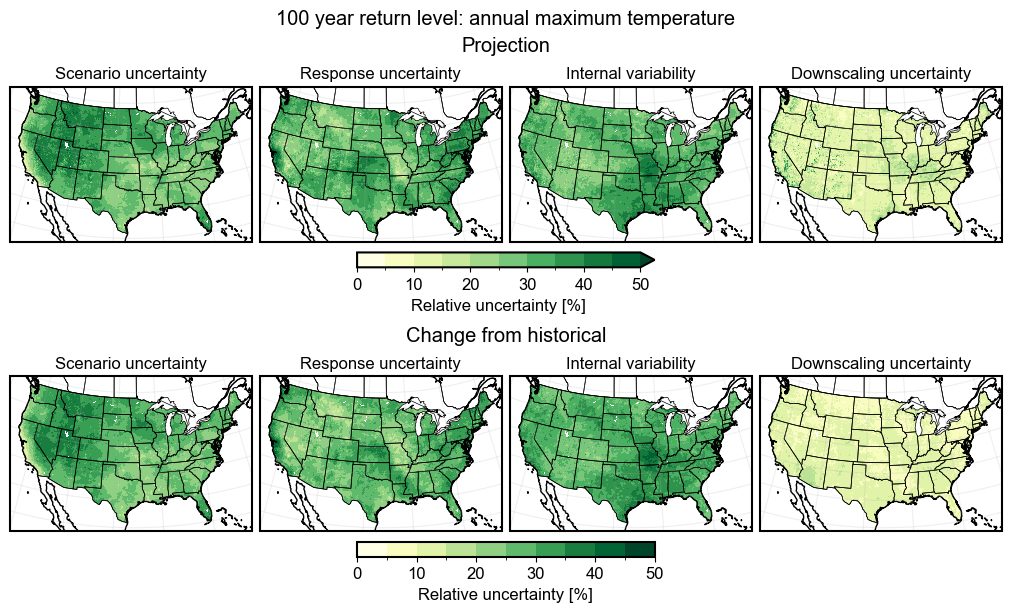

In [10]:
# max tasmax
metric_id = 'max_tasmax'
proj_slice = '2050-2100'
return_period = 100
norm = True
plot_uc_metric(metric_id, proj_slice, return_period, norm)

In [11]:
# # max tasmax
# metric_id = 'max_tasmax'
# proj_slice = '2050-2100'
# return_period = 100
# norm = False
# plot_uc_metric(metric_id, proj_slice, return_period, norm)

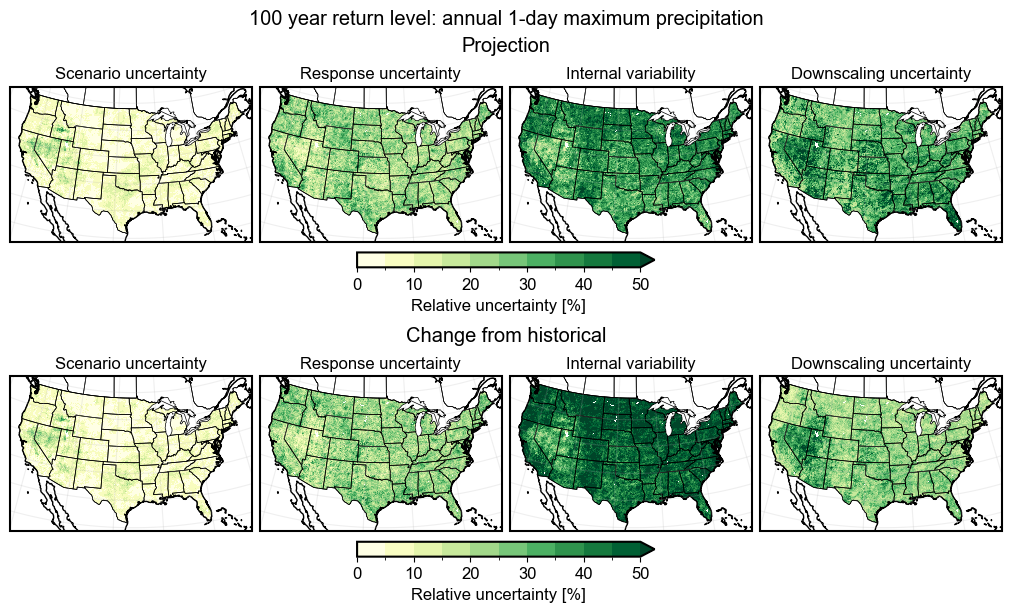

In [12]:
# max pr
metric_id = 'max_pr'
proj_slice = '2050-2100'
return_period = 100
norm = True
plot_uc_metric(metric_id, proj_slice, return_period, norm)

In [13]:
# # max pr
# metric_id = 'max_pr'
# proj_slice = '2050-2100'
# return_period = 100
# norm = False
# plot_uc_metric(metric_id, proj_slice, return_period, norm)

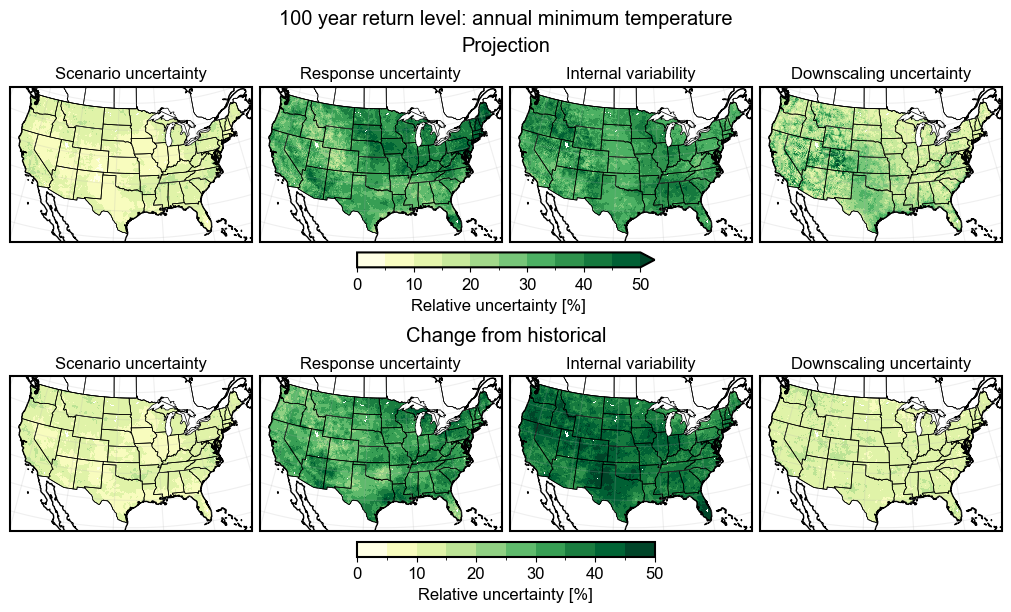

In [14]:
# min tasmin
metric_id = 'min_tasmin'
proj_slice = '2050-2100'
return_period = 100
norm = True
plot_uc_metric(metric_id, proj_slice, return_period, norm)

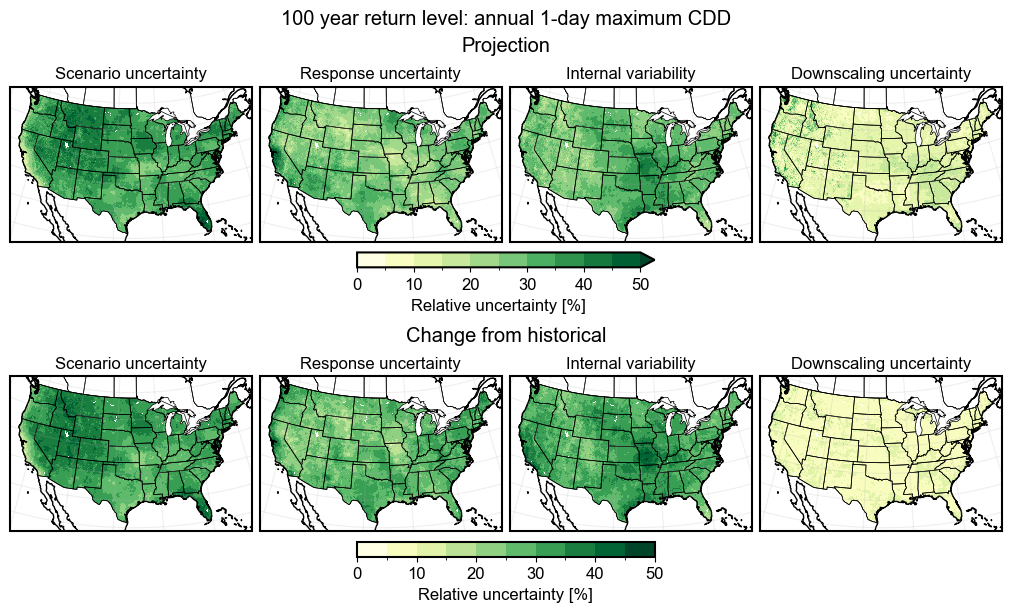

In [15]:
# max cdd
metric_id = 'max_cdd'
proj_slice = '2050-2100'
return_period = 100
norm = True
plot_uc_metric(metric_id, proj_slice, return_period, norm)

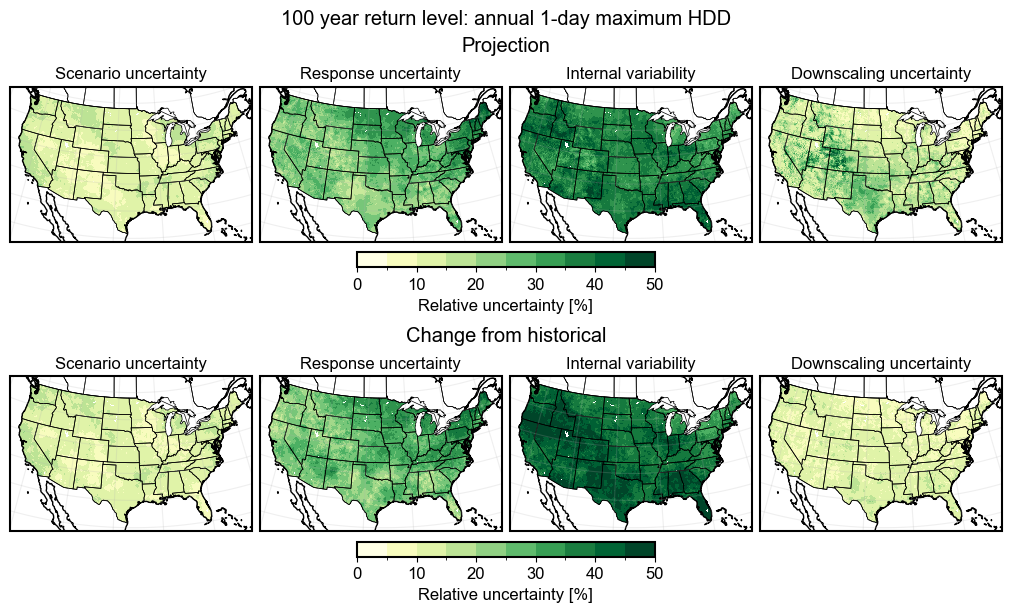

In [16]:
# max hdd
metric_id = 'max_hdd'
proj_slice = '2050-2100'
return_period = 100
norm = True
plot_uc_metric(metric_id, proj_slice, return_period, norm)